# 14wk-58: 전주시기온 / 시계열자료분석

최규빈  
2023-12-01

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-yixln2XzbeNxBzE2ikvG_X&si=1Cuilc0uG53am6Cr>

# 2. Imports

In [121]:
# !pip install autogluon.multimodal 

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#---#
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
#---#
import os
import warnings
warnings.filterwarnings('ignore')

# 3. Data

In [107]:
df = pd.read_csv('https://raw.githubusercontent.com/guebin/DV2022/master/posts/temp.csv').iloc[:,2:4].set_axis(['date','temp'],axis=1).assign(date= lambda df: df.date.apply(pd.to_datetime))
df_train = df[:580].assign(item_id = '평균기온')
df_test = df[580:].assign(item_id = '평균기온')

In [108]:
display(df_train.head())
display(df_test.head())

여기에서 세번째 칼럼은 오토글루온으로 시계열을 적합하기 위한 인덱스
역할을 함.

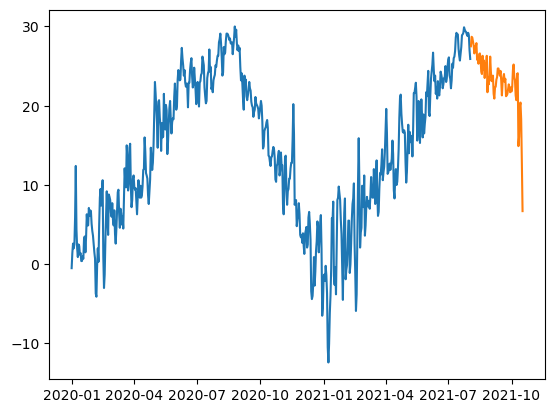

In [109]:
plt.plot(df_train.date,df_train.temp)
plt.plot(df_test.date,df_test.temp)

-   Tabular 형태의 자료분석이 맵핑 “X -\> y” 를 배우는 것이라면,
    시계열(timeseries)형태의 자료분석은 맵핑 “y과거 -\> y미래” 를 배우는
    것이다.

# 4. 시계열분석의 이해

`-` 개요: 오토글루온에서 tabular 자료의 분석과 timeseries 분석을
비교하면?

-   Tabular: `predictr.fit(df_trian)` / `predictr.predict(df_test)`
-   TimeSeries: `predictr.fit(ts_train)` / `predictr.predict(ts_train)`

> 실제로 시계열자료에서 `df_test`는 주어지지 않음.

`-` 오토글루온에서 분석가능한 시계열 자료의 형태

**1. 하나의 시계열**

In [110]:
df1 = pd.DataFrame({'시간':['2023-12-07','2023-12-08'], '종목':['삼성전자']*2, '주가':[72600, 72800]})
df1

In [111]:
ts1 = TimeSeriesDataFrame(
    data = df1,
    static_features = None, 
    id_column = '종목',
    timestamp_column = '시간'
)
ts1

**2. 여러개의 시계열**

In [112]:
df2 = pd.DataFrame({'시간':['2023-12-07','2023-12-08']*2, '종목':['삼성전자']*2+['카카오']*2, '주가':[72600, 72800, 51700, 51600]})
df2

In [113]:
ts2 = TimeSeriesDataFrame(
    data = df2,
    static_features = None, 
    id_column = '종목',
    timestamp_column = '시간'
)
ts2

**3. 여러개의 시계열 + static_feature**

In [114]:
df2 = pd.DataFrame({'시간':['2023-12-07','2023-12-08']*2, '종목':['삼성전자']*2+['카카오']*2, '주가':[72600, 72800, 51700, 51600]})
df3 = pd.DataFrame({'종목':['삼성전자','카카오'],'특징1(기업성격)':['제조','IT'],'특징2(사원수)':[500,25]})
display(df2,df3)
#---#
ts23 = TimeSeriesDataFrame(
    data = df2,
    static_features = df3, 
    id_column = '종목',
    timestamp_column = '시간'
)
ts23

# 5. 적합

## A. Step1: 데이터의 정리

In [115]:
ts_train = TimeSeriesDataFrame(
    data = df_train,
    static_features = None, 
    id_column = 'item_id',
    timestamp_column = 'date'
)

## B. Step2: `TimeSeriesPredictor` 생성

In [116]:
predictr = TimeSeriesPredictor(
    target = 'temp', # 예측하고 싶은것 
    known_covariates_names = None, # 온도를 예측할때 쓸 수 있는 다른 시계열 자료 
    prediction_length = len(df_test), # 예측하고 싶은 자료의 길이
    freq = 'D' # 주기 (보통은 'D', 'H'를 씀, 일반적으로 명시하지 않아도 오토글루온이 알아서 찾아줌) 
)

## C. Step3: 학습

In [117]:
predictr.fit(ts_train,presets='medium_quality')

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231209_020312'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.11.6
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #140-Ubuntu SMP Thu Aug 4 02:23:37 UTC 2022
CPU Count:          128
GPU Count:          1
Memory Avail:       401.20 GB / 503.74 GB (79.6%)
Disk Space Avail:   1159.47 GB / 1757.88 GB (66.0%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 76,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': 'temp',
 'verbosity': 2}

Provided train_data has 580 rows, 1 time series. Median time series length is 580 (min=580, max=580). 

Provided dataset cont

## D. Step4: 예측

In [118]:
predictr.predict(ts_train)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble

## E. 시각화

In [119]:
predictions = predictr.predict(ts_train)
predictions

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble

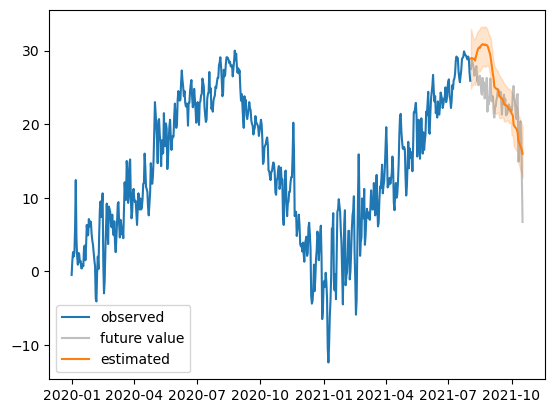

In [120]:
plt.plot(df_train.date,df_train.temp,label='observed')
plt.plot(df_test.date,df_test.temp,color='gray',alpha=0.5,label='future value')
plt.plot(df_test.date,predictions['mean'],color='C1',label='estimated')
plt.fill_between(df_test.date, predictions['0.1'], predictions['0.9'],color='C1',alpha=0.2)
plt.legend()

-   이정도 결과는 합리적으로 보임

# 5. 연구 및 토의

## A. `static_feature` vs `known_covariates`

`-` static은 시점에 따라 변화하지 않는 정보, known_covariates는 시점에
따라 변화하지만 이미 알고있는 미래시계열

-   분석타입1: fit(target의 현재까지자료) / forecast(target의
    현재까지자료) = target의 미래
-   분석타입2: fit(target의 현재까지자료,static_feature) -\>
    forecast(target의 현재까지자료,static_feature) = target의 미래
-   분석타입3: fit(target의 현재까지자료,known_covariates의
    현재까지자료) -\> forecast(target의 현재까지자료,known_covariates의
    미래) = target의 미래

## B. 장기예측

No path specified. Models will be saved in: "AutogluonModels/ag-20231209_020014"
Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231209_020014'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.11.6
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #140-Ubuntu SMP Thu Aug 4 02:23:37 UTC 2022
CPU Count:          128
GPU Count:          1
Memory Avail:       403.68 GB / 503.74 GB (80.1%)
Disk Space Avail:   1159.48 GB / 1757.88 GB (66.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 143,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': 'temp',
 'verbosity': 2}

Provided train_data has 513 rows, 1 time series. Median time series length i

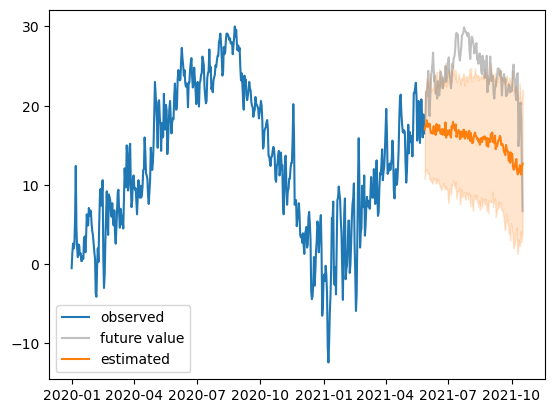

In [102]:
df = pd.read_csv('https://raw.githubusercontent.com/guebin/DV2022/master/posts/temp.csv').iloc[:,2:4].set_axis(['date','temp'],axis=1).assign(date= lambda df: df.date.apply(pd.to_datetime))
df_train = df[:513].assign(item_id = '평균기온')
df_test = df[513:].assign(item_id = '평균기온')
#---#
## step1 
ts_train = TimeSeriesDataFrame(
    data = df_train,
    static_features = None, 
    id_column = 'item_id',
    timestamp_column = 'date'
)
## step2 
predictr = TimeSeriesPredictor(
    target = 'temp', # 예측하고 싶은것 
    known_covariates_names = None, # 온도를 예측할때 쓸 수 있는 다른 시계열 자료 
    prediction_length = len(df_test), # 예측하고 싶은 자료의 길이
    freq = 'D' # 주기 (보통은 'D', 'H'를 씀, 일반적으로 명시하지 않아도 오토글루온이 알아서 찾아줌) 
)
## step3 
predictr.fit(ts_train)
## step4 
predictr.predict(ts_train)
#---# 
predictions = predictr.predict(ts_train)
plt.plot(df_train.date,df_train.temp,label='observed')
plt.plot(df_test.date,df_test.temp,color='gray',alpha=0.5,label='future value')
plt.plot(df_test.date,predictions['mean'],color='C1',label='estimated')
plt.fill_between(df_test.date, predictions['0.1'], predictions['0.9'],color='C1',alpha=0.2)
plt.legend()

-   장기예측은 그럴듯하지 않아보임 – 장기예측은 (좁은의미의)시계열분석의
    범위를 벗어남

`-` 통계학과에서 배우는 시계열분석

-   주식시계열: 독립인듯 하지만, 사실은 독립이 아닌자료. 즉 “관측자료 =
    정보 + 오차” 인데, 오차항이 독립이 아닐 경우.
-   오차항이 독립이 아니라는 의미: 주식시계열이 비합리적인 관측자료라는
    의미임. (사실 오차항은 독립이어야 하지 않냐?)
-   주식시계열자료의 새로운해석: 원래 우리가 통계에서 다루는 셋팅은
    “관측자료 = 정보 + 오차”이다.[1]. 이를 시계열로 바꿔서 표현하면
    “주식시계열자료 = 합리적정보 + 오차 = 합리적정보 + (기세 +
    독립오차)”
-   시계열분석: 통계학과에서 배우는 시계열모형들은 “기세”를 모델링하는
    것임. 즉 비합리적인 오차항을 모델링 하는 것!
    -   1시점 전의 기세의 영향을 얼만큼 강하게 볼지 결정하는 일은,
        AR(1)의 계수값을 결정하는 일과 같은 일이다.
    -   몇 시점까지의 기세를 봐야할지 결정하는 일은 AR(p)모형에서 p의
        값을 결정하는 일과 같은 일이다.
    -   100시점 전까지의 기세를 보고싶다면, 원칙적으로는 AR(100)을
        적합해야하지만 그렇다면 너무 학습할 파라메터가 많을 것임. 하지만
        이론에 따라서 AR(100)과 비슷한 효과를 주고 파라메터를 더 적게
        가지는 MA(q), ARMA(p,q) 와 같은 모형이 존재함이 밝혀짐. 그래서
        아주 먼 시점의 기세까지 파악하여 분석해야 한다면 ARMA(p,q)를
        적합하는 것이 유리함.
    -   트렌드와 계절성을 가지는 시계열 자료는 기세를 모델링하기
        어려운데 어쩌지? 제거하고 분석 (ARIMA, SARIMA 등의 개발)
    -   기세의 변동성이 시간에 따라 달라진다면 어쩌지? ARCH, GARCH 의
        개발
-   평균정보: 시계열분석에서 합리적정보(평균정보)는 `static_feature`,
    `known_covariates` 에 포함되어있다.
-   장기예측: 장기예측은 평균정보를 잘 추정하는것이 중요하며, 이는
    기세를 모델링하는 것과는 별 상관이 없다. (즉 “좁은”의미의
    시계열분석과 상관이 없다)
-   파업선언: 시계열로 장기예측을 해라? 저는 그냥 다른 방법을 썼어요..

[1] 참고로 기존에 우리가 다루었던 자료는 엄밀하게 쓰면 “관측자료 =
정보 + 독립오차” 임